In [1]:
import numpy as np
import pandas as pd
import random
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [57]:
train_dataset = pd.read_csv('content/optiver-trading-at-the-close/train.csv')
train_dataset.head(30)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


In [83]:
train_dataset_time_sorted = train_dataset.sort_values('time_id')

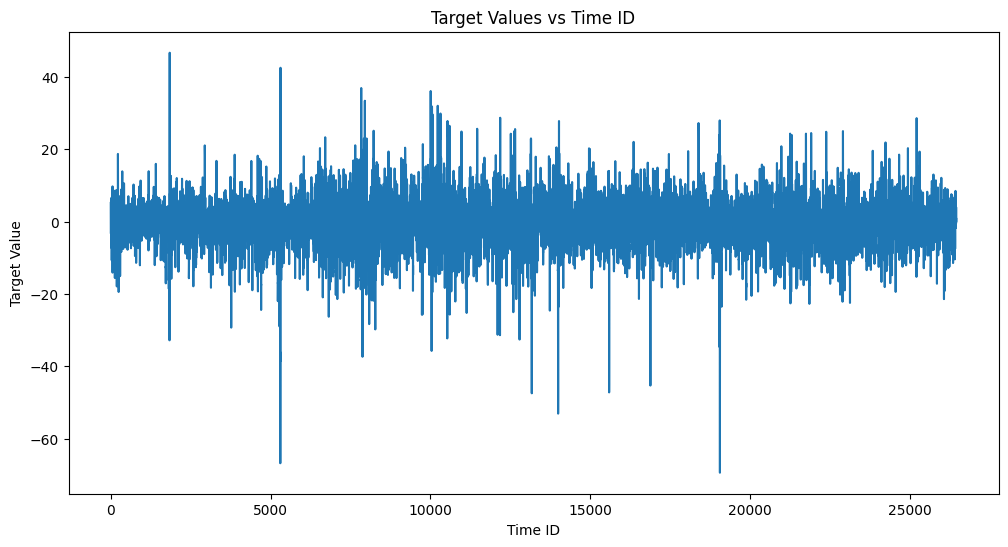

In [64]:
import matplotlib.pyplot as plt
example_0 = train_dataset[train_dataset['stock_id'] == 0]
plt.figure(figsize=(12, 6))
plt.plot(example_0['time_id'], example_0['target'])
plt.xlabel('Time ID')
plt.ylabel('Target Value')
plt.title('Target Values vs Time ID')
plt.show()


<Axes: xlabel='date_id'>

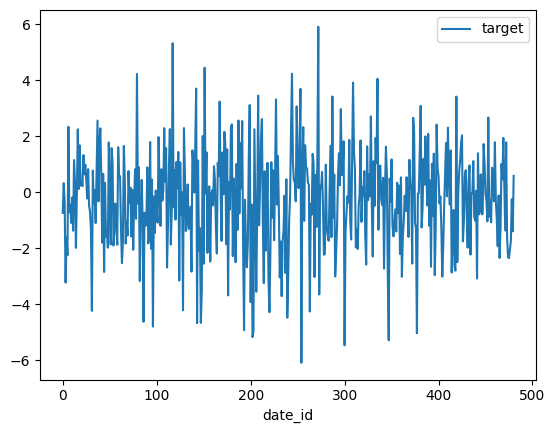

In [66]:
example_0.groupby('date_id').agg({'target':'mean'}).plot()

In [86]:
features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'time_id']#, 'near_price_norm', 'far_price_norm',
#             'volume', 'ask_ref_ratio', 'bid_ref_ratio', 'ask_imb_ratio', 'bid_imb_ratio', 'ask_mat_ratio', 'bid_mat_ratio']
# features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
#             'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'near_price', 'far_price']

In [99]:
max_values = np.max(X_train[:, :, -1], axis=1)
max_values.max()

21216.0

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Assuming example_0 is your DataFrame and 'target' is the column you want to predict
train_dataset_time_sorted_drop = train_dataset_time_sorted[features+['target']].dropna()
X = train_dataset_time_sorted_drop.drop('target', axis=1)
y = train_dataset_time_sorted_drop['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

max_values_train = np.max(X_train[:, :, -1], axis=1)
max_values_test = np.max(X_test[:, :, -1], axis=1)

timesteps = max_values_train.max()
forcast_horizon = max_values_test.max() - timesteps

In [111]:
X_train

array([[[ 3.18060269e+06,  1.00000000e+00,  9.99812000e-01, ...,
          8.49303000e+03,  1.00000000e+00,  0.00000000e+00]],

       [[ 2.98374515e+06,  1.00000000e+00,  9.99567000e-01, ...,
          2.33100000e+04,  1.00000000e+00,  0.00000000e+00]],

       [[ 6.23714790e+05,  1.00000000e+00,  9.99563000e-01, ...,
          2.15196000e+04,  1.00000000e+00,  0.00000000e+00]],

       ...,

       [[ 2.27344490e+05,  1.00000000e+00,  1.00122000e+00, ...,
          1.27070400e+04,  1.00110800e+00,  2.12160000e+04]],

       [[ 1.07805388e+06, -1.00000000e+00,  9.96737000e-01, ...,
          2.09500000e+04,  9.96992000e-01,  2.12160000e+04]],

       [[ 0.00000000e+00,  0.00000000e+00,  1.00098800e+00, ...,
          1.04322240e+05,  1.00089800e+00,  2.12160000e+04]]])

In [115]:
X_train[:,:, :9]
X_test[:,:, :9]

#X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Define the RNN model
model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, 1, X_train.shape[2]), stateful=True))
model.add(Dense(forcast_horizon))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

# Make predictions
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

4190208/4190208 - 14613s - loss: 90.1897 - 14613s/epoch - 3ms/step


KeyboardInterrupt: 

In [56]:
train_dataset_drop = train_dataset[features+['target']].dropna()
train_dataset_drop.head(30)

,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target
0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,0.00,0,1.000635,13552875.92,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,969969.40,1,1.000115,3647503.98,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,9412959.10,1,0.999818,21261245.87,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,2394875.85,1,0.999916,9473209.08,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,3039700.65,-1,1.000969,6248958.45,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


In [35]:
X = train_dataset_drop.drop(columns='target')
y = train_dataset_drop[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) #shuffle=False?
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3561676, 9) (1047552, 9)
(3561676, 1) (1047552, 1)


In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, GRU, SimpleRNN, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
x_val_scaled = scaler.transform(X_val)

# scaler_y = MinMaxScaler()
# y_train_scaled = scaler_y.fit_transform(y_train)
# y_test_scaled = scaler_y.transform(y_test)
# y_val_scaled = scaler_y.transform(y_val)


In [17]:
x_train_scaled.shape

(4190208, 9)

In [42]:
# model = Sequential()
# model.add(Embedding(input_dim=9, output_dim=64))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='softmax'))


model = Sequential()
model.add(Embedding(input_dim=9, output_dim=64))
model.add(GRU(256, activation='relu', return_sequences=True))
model.add(Conv1D(64, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(SimpleRNN(128, activation='relu', return_sequences=True))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dense(64, activation='relu'))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [43]:
#model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(x_train_scaled, y_train, epochs=5, batch_size=128, validation_data=(x_val_scaled, y_val))


Epoch 1/5
27826/27826 [==============================] - 1571s 56ms/step - loss: 1.3028e-04 - mean_absolute_error: 0.0077 - val_loss: 1.2869e-04 - val_mean_absolute_error: 0.0077
Epoch 2/5
27826/27826 [==============================] - 1200s 43ms/step - loss: 1.2965e-04 - mean_absolute_error: 0.0077 - val_loss: 1.2999e-04 - val_mean_absolute_error: 0.0078
Epoch 3/5
27826/27826 [==============================] - 1185s 43ms/step - loss: 1.2960e-04 - mean_absolute_error: 0.0077 - val_loss: 1.2868e-04 - val_mean_absolute_error: 0.0077
Epoch 4/5
27826/27826 [==============================] - 1187s 43ms/step - loss: 1.2957e-04 - mean_absolute_error: 0.0077 - val_loss: 1.2870e-04 - val_mean_absolute_error: 0.0077
Epoch 5/5
27826/27826 [==============================] - 1182s 42ms/step - loss: 1.2957e-04 - mean_absolute_error: 0.0077 - val_loss: 1.2871e-04 - val_mean_absolute_error: 0.0077


In [54]:
pred_y.reshape(pred_y.shape[0], 1)

(1047552, 1)

In [ ]:
pred_y = model.predict(x_test_scaled)

In [55]:
pred_y = scaler_y.inverse_transform(pred_y.reshape(pred_y.shape[0], 1))
print("Baseline RNN MAE: ",mean_absolute_error(y_test, pred_y))

Baseline RNN MAE:  6.403345194111428


In [44]:
results = history.evals_result()
epochs = len(results['validation_0']['mae'])

# Extract the MAE information from results
train_mae = results['validation_0']['mae']
val_mae = results['validation_1']['mae']

# Plotting the training and validation MAE
plt.plot(range(1, epochs + 1), train_mae, label='Training MAE')
plt.plot(range(1, epochs + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'History' object has no attribute 'evals_result'

In [30]:
model = Sequential()
model.add(Embedding(input_dim=9, output_dim=128))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
#model.add(LSTM(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(x_train_scaled, y_train, epochs=5, batch_size=128, validation_data=(x_test_scaled, y_test))

Epoch 1/5
 8952/32736 [=======>......................] - ETA: 39:32 - loss: 6.4690

KeyboardInterrupt: 

In [ ]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("kryox64/stock-x")
model.summary()